In [1]:
from src.utils.data_utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [ ]:
## * see further dowm for import, same as results.ipynb

# # load breweries file
# breweries_df = pd.read_csv("data/clean/BeerAdvocate/breweries.csv")


In [24]:

def get_ba_beer_merged():
    ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
    ba_usa_users = pd.read_csv("data/clean/BeerAdvocate/usa_users.csv")

    ba_usa_ratings = ba_usa_ratings.merge(ba_usa_users[['user_id', 'location']], on='user_id', how='left')
    ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])
    ba_usa_ratings['date'] = ba_usa_ratings['date'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).date())
    # datetime.fromtimestamp(timestamp) 
    return ba_usa_ratings


ba_usa_ratings = get_ba_beer_merged()


# # load rating to know when was the first rating
# ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
# ba_usa_ratings['date'] = ba_usa_ratings['date'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).date())

In [ ]:
### same code as results.ipynb
def load_breweries():
    breweries = pd.read_csv("data/clean/BeerAdvocate/breweries.csv")
    breweries['location'] = breweries['location'].apply(lambda x: x.replace('United States, ', ''))
    breweries['state'] = breweries['location'].apply(lambda x: x.split(', ')[-1])
    breweries.loc[breweries['location'].str.contains('Canada, '), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('Ontario'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('Quebec'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('Nova Scotia'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('Manitoba'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('British Columbia'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('Alberta'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('Newfoundland and Labrador'), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('United Kingdom, '), 'location'] = 'United Kingdom'
    breweries = breweries.rename(columns={'id': 'brewery_id'})
    
    return breweries



breweries_df = load_breweries()

breweries_df

<bound method Series.unique of 0            Kyrgyzstan
1            Kyrgyzstan
2            Kyrgyzstan
3            Kyrgyzstan
4            Kyrgyzstan
              ...      
16753           Germany
16754             Aruba
16755          New York
16756    North Carolina
16757          Maryland
Name: location, Length: 16758, dtype: object>

In [99]:
def breweries_first_date(reviews_df, brew_df):
    rev = reviews_df.loc[:, ['brewery_id', 'date']].sort_values('date').drop_duplicates(subset=['brewery_id'])
    #print(rev)
    
    #breweries_df['first_rev'] = None
    #breweries_df['first_rev'] = breweries_df.apply(lambda x: rev[rev['brewery_id'] == x.id]['date'], axis=1)

    # breweries_df
    # for index, brewery in brew_df.iterrows():
    #     try:
    #         brew_df.loc[index, 'first_rev'] = rev[rev['brewery_id'] == brewery['id']]['date'].values[0]
    #     except IndexError:
    #         num_not_rated_us += 1

    brew_df['first_rev']=brew_df['brewery_id'].map(dict(zip(rev.brewery_id,rev.date)))
    brew_df = brew_df.dropna(subset=['first_rev'])
    brew_df.loc[:,'year_month'] = pd.to_datetime(brew_df.loc[:,'first_rev']).dt.to_period('M')
    #first_review = 

    return brew_df

def monthly_new_breweries(brew_df):
    new_brew = brew_df.value_counts(subset=['year_month'], sort=False).to_frame().reset_index()
    #new_brew['year_month'] = new_brew['year_month'].dt.to_timestamp()
    # need to fill gaps to plot later:
    #new_brew = new_brew.set_index('year_month').resample('ME')

    new_brew['cumulative'] = new_brew['count'].cumsum()
    
    return new_brew

In [85]:
US_State_index = pd.unique(ba_usa_ratings['state'])


new_breweries = breweries_first_date(ba_usa_ratings, breweries_df)


In [86]:
new_breweries.year_month

8        2015-08
9        2004-11
11       2001-04
12       2016-09
13       2004-03
          ...   
16744    2005-04
16748    2007-08
16751    2002-12
16753    2001-01
16756    2007-10
Name: year_month, Length: 11243, dtype: period[M]

In [100]:

brew_world = monthly_new_breweries(new_breweries)
brew_us = monthly_new_breweries(new_breweries[new_breweries['location'].isin(US_State_index)])

In [101]:
brew_world

,year_month,count,cumulative
0,1996-08,1,1
1,1998-01,4,5
2,1998-02,9,14
3,1998-03,8,22
4,1998-04,3,25
...,...,...,...
224,2017-03,96,10790
225,2017-04,96,10886
226,2017-05,113,10999
227,2017-06,149,11148


In [34]:
# reviews per brewery

def reviews_per_brewery(reviews_df, brew_df):
    rev = reviews_df.loc[:, ['brewery_id', 'brewery_name', 'date']].groupby('brewery_name').count()
    #print(rev)
    # date hase the number of counts
    brew_df['review_count']=brew_df['brewery_id'].map(dict(zip(rev.brewery_id,rev.date))).fillna(0).astype(int)

    index_names = brew_df[ brew_df['review_count'] == 0 ].index 
    brew_df.drop(index_names, inplace = True) 

    #brew_df.dropna(subset = ['review_count'], inplace=True)

    return brew_df

In [35]:
test = reviews_per_brewery(ba_usa_ratings, breweries_df)
test

,Unnamed: 0,brewery_id,location,name,nbr_beers,state,first_rev,year_month,review_count
11,11,297,Northern Ireland,Thomas Caffrey Brewing Co.,2,Northern Ireland,2001-04-03,2001-04,297
99,99,323,Scotland,Harviestoun Brewery Ltd.,74,Scotland,2001-09-10,2001-09,323
105,105,649,Scotland,Isle of Arran Brewery Company Ltd.,12,Scotland,2004-03-07,2004-03,649
107,107,577,Scotland,Isle Of Skye Brewery,18,Scotland,2003-07-14,2003-07,577
116,116,80,Scotland,Strathaven Ales,14,Scotland,2005-03-26,2005-03,80
...,...,...,...,...,...,...,...,...,...
16728,16728,1059,Washington,Bell Tower Restaurant and Brewhouse,0,Washington,NaN,NaT,1059
16733,16733,2016,Michigan,Lighthouse Brewing Company,2,Michigan,2002-08-10,2002-08,2016
16736,16736,237,Massachusetts,Quincy Ships Brewing Company,11,Massachusetts,2002-03-16,2002-03,237
16743,16743,420,Kentucky,Oldenberg Brewing Company,5,Kentucky,2001-08-16,2001-08,420


In [107]:

# should be how=left mais fout la merde
cum_brew = brew_world.merge(brew_us, left_index=True, right_index=True, suffixes=('_World', '_US'))

#cum_brew = cum_brew.fillna(0)

cum_brew['frac'] = cum_brew['cumulative_US'] / cum_brew['cumulative_World']
cum_brew

,year_month_World,count_World,cumulative_World,year_month_US,count_US,cumulative_US,frac
0,1996-08,1,1,1996-08,1,1,1.000000
1,1998-01,4,5,1998-01,3,4,0.800000
2,1998-02,9,14,1998-02,7,11,0.785714
3,1998-03,8,22,1998-03,3,14,0.636364
4,1998-04,3,25,1998-04,1,15,0.600000
...,...,...,...,...,...,...,...
220,2016-11,77,10446,2017-03,69,6036,0.577829
221,2016-12,77,10523,2017-04,67,6103,0.579968
222,2017-01,99,10622,2017-05,68,6171,0.580964
223,2017-02,72,10694,2017-06,94,6265,0.585843


Text(0, 0.5, 'Number of breweries')

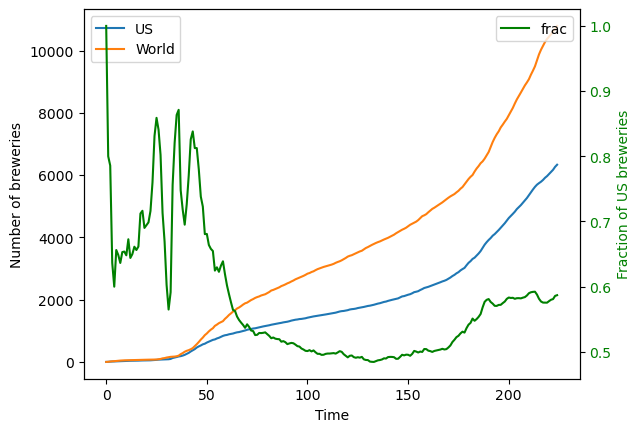

In [109]:


fig, ax = plt.subplots(1, 1)
cum_brew.plot(y= ['cumulative_US', 'cumulative_World'], ax=ax, label=['US', 'World'])
#brew_us['cumulative'].plot(ax=ax, label='US')
ax.set_xlabel('Time')

ax.legend()

ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
cum_brew.plot(y= ['frac'], ax=ax2, color='g')
ax2.set_ylabel('Fraction of US breweries', color='g')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='g')

ax.set_ylabel("Number of breweries")

Need to have the number of new breweries per month per state

same plot as distances per state so can plot together
data per year_month
Function to call:
for i, (state, df) in enumerate(user_state_dic.items()):
In user_state_dic: 

#gather monthly data
for key in user_state_dic.keys():
    
    monthly_data = user_state_dic[key].groupby('year_month')

In [ ]:

# don't need as new_breweries is already calculated first rating
#breweries = load_breweries()


In [110]:
brewery_state_dic = {}

# the list of state names is the list of unique values of the state of origin of the users, as we only have reviews from users in the US
for state in pd.unique(ba_usa_ratings['state']):
    # New_breweries has already the first review date
    brewery_state_dic[state] = new_breweries[new_breweries['state'] == state]

brewery_state_dic.keys()

dict_keys(['Washington', 'New York', 'Kansas', 'New Jersey', 'North Carolina', 'Oklahoma', 'Pennsylvania', 'California', 'Wisconsin', 'Illinois', 'Virginia', 'Massachusetts', 'South Carolina', 'Georgia', 'Louisiana', 'West Virginia', 'Alabama', 'New Hampshire', 'Indiana', 'Rhode Island', 'Missouri', 'Arkansas', 'Ohio', 'Connecticut', 'Florida', 'Minnesota', 'Maryland', 'Alaska', 'Mississippi', 'Iowa', 'Oregon', 'Kentucky', 'Michigan', 'Colorado', 'Texas', 'Arizona', 'Montana', 'Hawaii', 'Idaho', 'Delaware', 'Tennessee', 'Wyoming', 'Maine', 'Vermont', 'New Mexico', 'Nevada', 'Nebraska', 'Utah', 'North Dakota', 'South Dakota'])

In [111]:
# make dict with new breweries per state and cumulative number

new_brew_state_dic = {key: {} for key in brewery_state_dic.keys()}
for key in brewery_state_dic.keys():
    new_brew_state_dic[key] = monthly_new_breweries(brewery_state_dic[key])

print(new_brew_state_dic['West Virginia'])

   year_month  count  cumulative
0     2002-09      1           1
1     2003-01      1           2
2     2003-09      1           3
3     2004-08      1           4
4     2006-02      1           5
5     2006-05      1           6
6     2009-11      1           7
7     2010-04      1           8
8     2013-07      1           9
9     2013-09      1          10
10    2014-03      1          11
11    2014-06      1          12
12    2014-08      1          13
13    2014-10      1          14
14    2015-03      1          15
15    2016-03      1          16
16    2016-06      1          17
17    2016-10      1          18
18    2017-01      1          19
19    2017-03      1          20


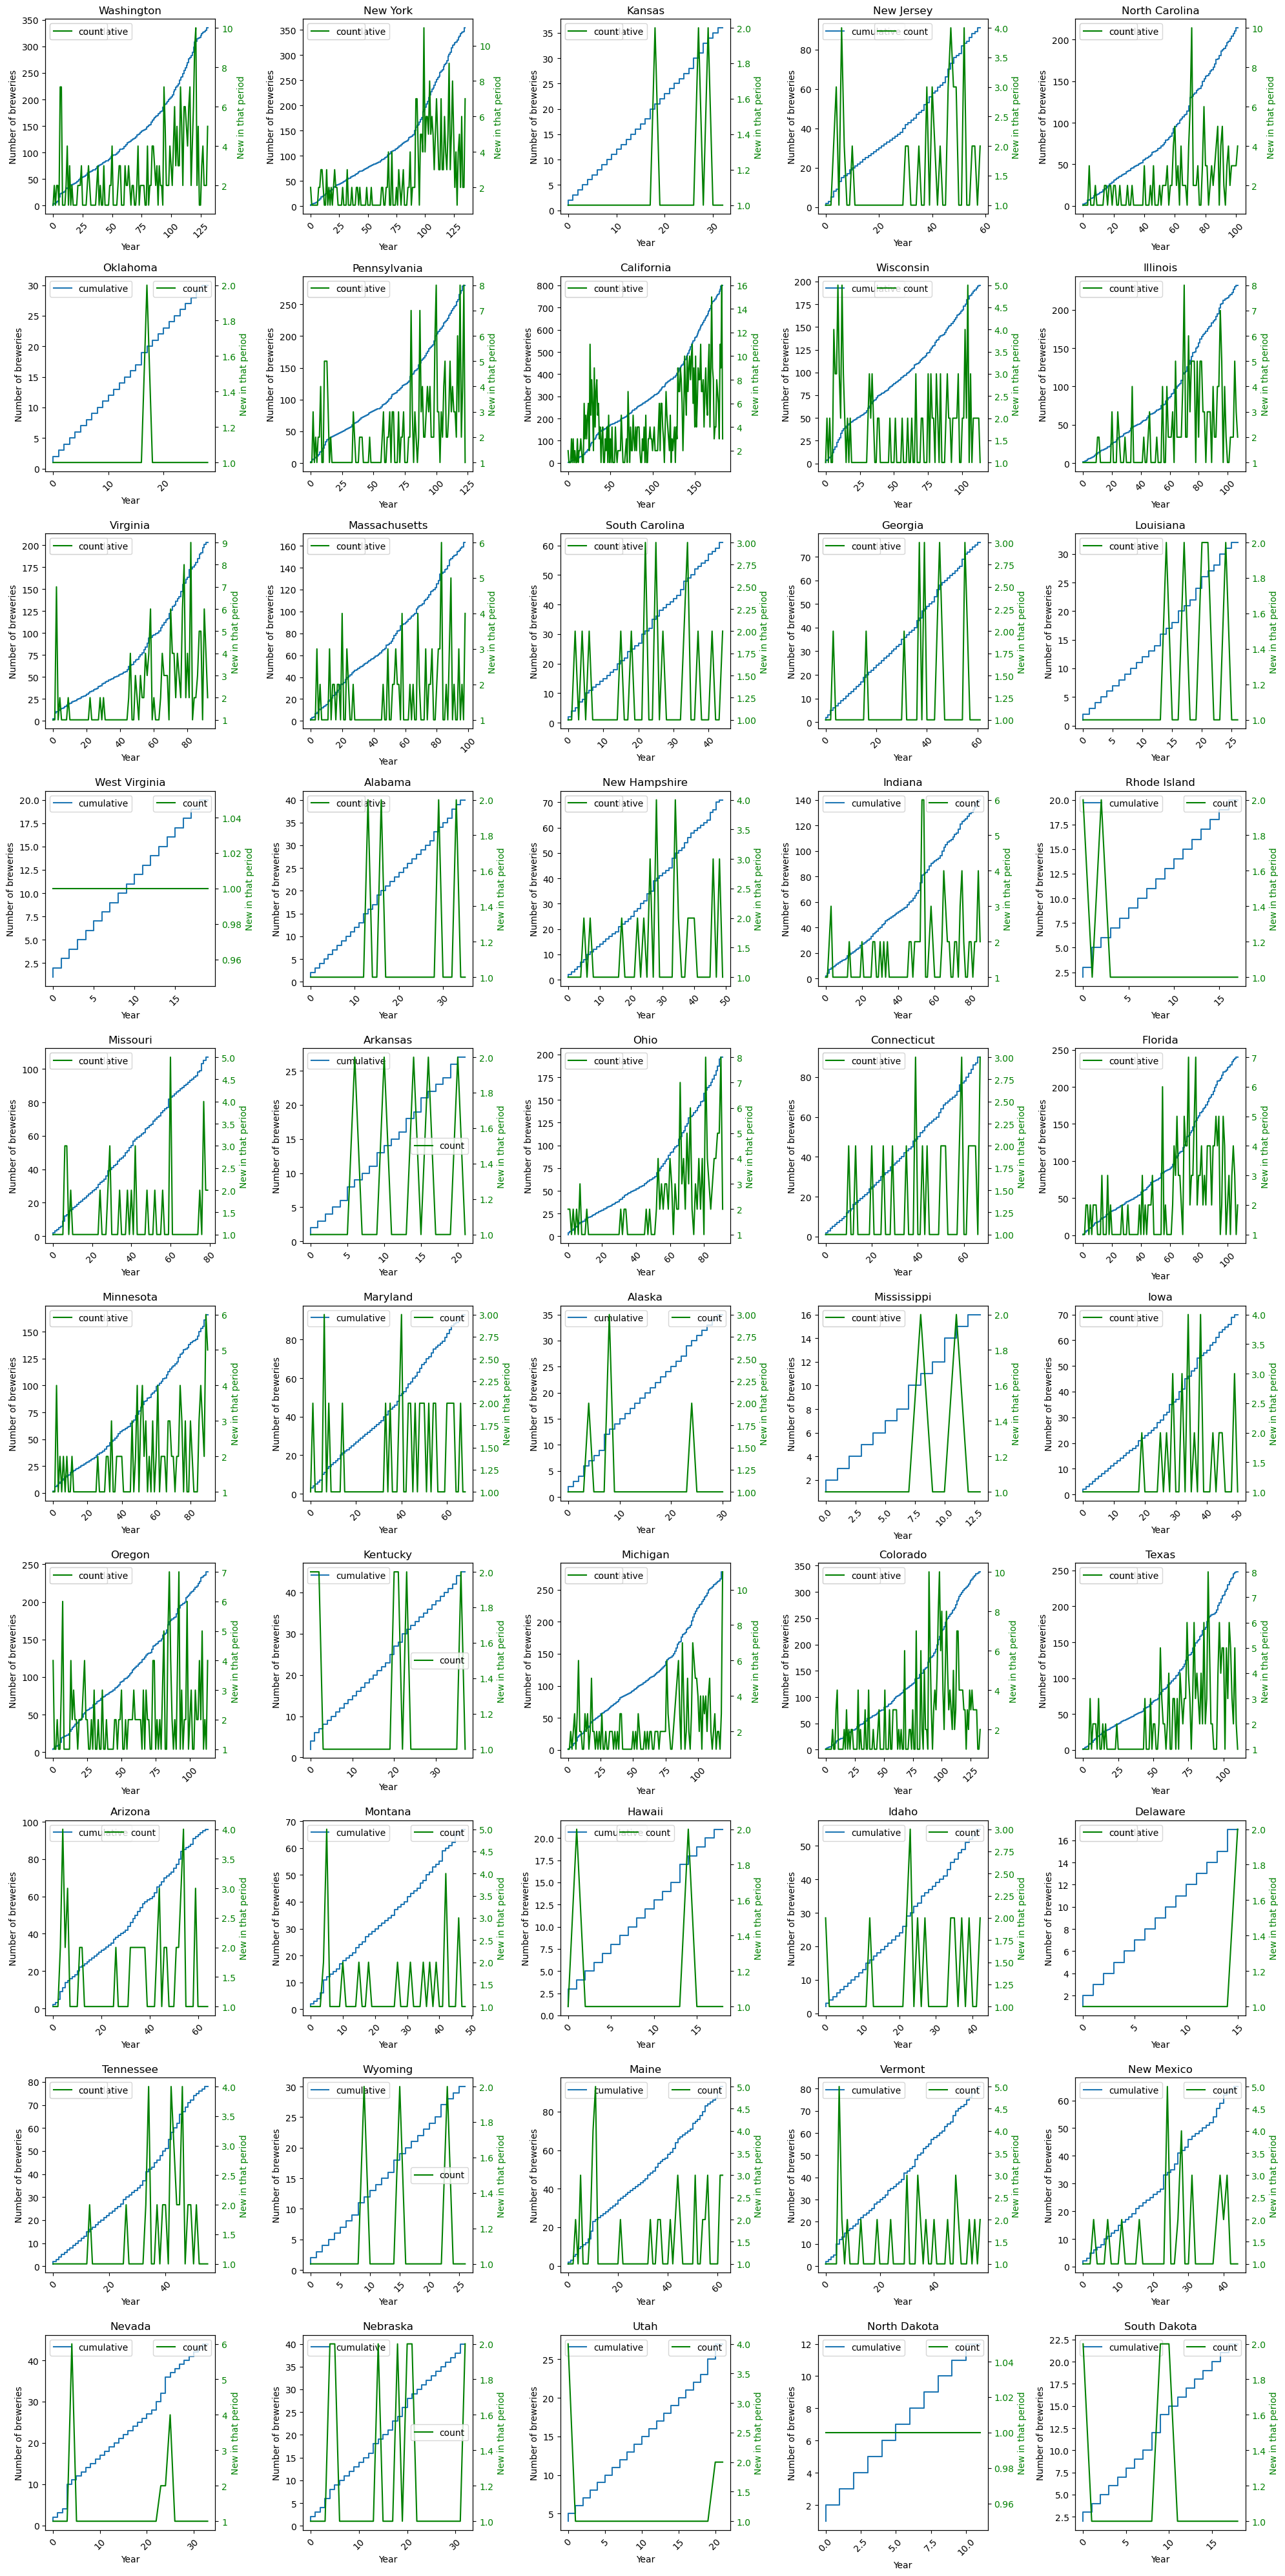

In [114]:
import math
num_states = len(new_brew_state_dic)
cols = 5
rows = math.ceil(num_states / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axs = axs.flatten()

for i, (state, df) in enumerate(new_brew_state_dic.items()):
    #monthly_avg = df.groupby('year_month')['distance'].mean()
    df.plot(drawstyle="steps", y= ['cumulative'], ax=axs[i], linestyle='-')
    axs[i].set_title(f"{state}")
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Number of breweries")
    axs[i].tick_params(axis='x', rotation=45)

    ax2 = axs[i].twinx()  # instantiate a second Axes that shares the same x-axis
    df.plot(y= ['count'], ax=ax2, color='g')
    ax2.set_ylabel('New in that period', color='g')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='g')


plt.tight_layout()
plt.show()